In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import lsst.afw.display.rgb as rgb
from scipy import interpolate

from astropy.table import Table
import matplotlib
import matplotlib.mlab as mlab
import numpy as np

import lsst.afw.display as afwDisplay
from python.simulation_utils import simulation_wrapper, OpSim_wrapper
from python.notebook_utils import look, get_xkcd_color, load_diffim, plot_diffim_quiver, dcr_metric
import lsst.daf.persistence as daf_persistence
from lsst.ip.diffim.dcrModel import calculateDcr

In [2]:
base_dir = "/Users/sullivan/LSST/simulations/OpSim/"

OpSim baseline2018a

In [3]:
opsim_version = "pontus_2568/"

In [4]:
constPSF_run = "mosaic_1_constPSF_rand/"
varPSF_run = "mosaic_1_varPSF_rand/"

In [5]:
dcr_rerun = "input_data/rerun/processed_data/rerun/year1_dcr_template_fullboost/"
deep_rerun = "input_data/rerun/processed_data/rerun/year1_cw_template/"

In [6]:
visits_alerts_string = "2268200..2268206^2272500..2272512^2287400..2287402^2035900..2035911^2257600..2257608^2258500..2258508^2273300..2273311^2267300..2267306^2277500..2277504"
visits_alerts = [[int(visit) for visit in visits.split("..")] for visits in visits_alerts_string.split("^")]

In [7]:
visits_template_string = "1268200..1268209^1272500..1272507^1287400..1287405^1035900..1035911^1257600..1257609^1258500..1258509^1273300..1273311^1267300..1267303^1277500..1277509"
visits_template = [[int(visit) for visit in visits.split("..")] for visits in visits_template_string.split("^")]

In [8]:
visits_template_goodSeeing_string = "1268200..1268202^1268204..1268209^1272500..1272502^1272504..1272505^1272507^1287400..1287405^1035900..1035903^1035905^1035906^1035909..1035911^1257600..1257606^1257608^1257609^1258500..1258509^1273300..1273311^1267300..1267303^1277501^1277504..1277505^1277507..1277509"
visits_template_goodSeeing = [[int(visit) for visit in visits.split("..")] for visits in visits_template_goodSeeing_string.split("^")]
for visits in visits_template_goodSeeing:
    if len(visits) == 1:
        visits.append(visits[0])

In [9]:
visits_template_goodSeeing

[[1268200, 1268202],
 [1268204, 1268209],
 [1272500, 1272502],
 [1272504, 1272505],
 [1272507, 1272507],
 [1287400, 1287405],
 [1035900, 1035903],
 [1035905, 1035905],
 [1035906, 1035906],
 [1035909, 1035911],
 [1257600, 1257606],
 [1257608, 1257608],
 [1257609, 1257609],
 [1258500, 1258509],
 [1273300, 1273311],
 [1267300, 1267303],
 [1277501, 1277501],
 [1277504, 1277505],
 [1277507, 1277509]]

In [10]:
const_template_deep, const_alerts_deep = load_diffim(base_dir + opsim_version + constPSF_run,
                                                     deep_rerun, dcr_rerun,
                                                     visits_template, visits_alerts,
                                                     filter_name='g', coaddName='deep')

In [11]:
const_template_dcr, const_alerts_dcr = load_diffim(base_dir + opsim_version + constPSF_run,
                                                   deep_rerun, dcr_rerun,
                                                   visits_template, visits_alerts,
                                                   filter_name='g', coaddName='dcr')

In [12]:
var_template_deep, var_alerts_deep = load_diffim(base_dir + opsim_version + varPSF_run,
                                                   deep_rerun, dcr_rerun,
                                                   visits_template, visits_alerts,
                                                   filter_name='g', coaddName='deep')

In [13]:
var_template_dcr, var_alerts_dcr = load_diffim(base_dir + opsim_version + varPSF_run,
                                                 deep_rerun, dcr_rerun,
                                                 visits_template_goodSeeing, visits_alerts,
                                                 filter_name='g', coaddName='dcr')

from scipy.spatial import ConvexHull

In [14]:
def plot_dcr(field_table, fieldId):
    fields = set(field_table["fieldId"])
    if fieldId not in fields:
        print('ValueError("fieldId not found in table")')
    rows = field_table["fieldId"] == fieldId
    dcr = field_table["dcr"].data[rows]
    return dcr

In [15]:
set(var_template_dcr["fieldId"])

{'0359', '2576', '2585', '2673', '2682', '2725', '2733', '2775', '2874'}

In [16]:
disp = afwDisplay.Display(1)

In [17]:
metrics = {}
for fieldId in list(set(var_template_dcr["fieldId"])):
    metric = dcr_metric(var_template_dcr, fieldId)
    metrics[fieldId] = metric
print(metrics)

{'2682': 7.581041731890382, '2775': 3.7535603330590246, '2874': 5.712088991168171, '2673': 3.414213562373095, '2725': 4.86595681848744, '2576': 7.6834805308013365, '0359': 8.20611508118367, '2585': 6.830863555721491, '2733': 6.222501288087549}


In [18]:
field_list = list(set(const_template_deep["fieldId"]))

In [19]:
field_list

['2682', '2775', '2874', '2673', '2725', '2576', '0359', '2585', '2733']

In [20]:
np.mean(const_alerts_deep["nDipole"])

18.714285714285715

In [21]:
np.mean(const_alerts_dcr["nDipole"])

7.545454545454546

<IPython.core.display.Javascript object>


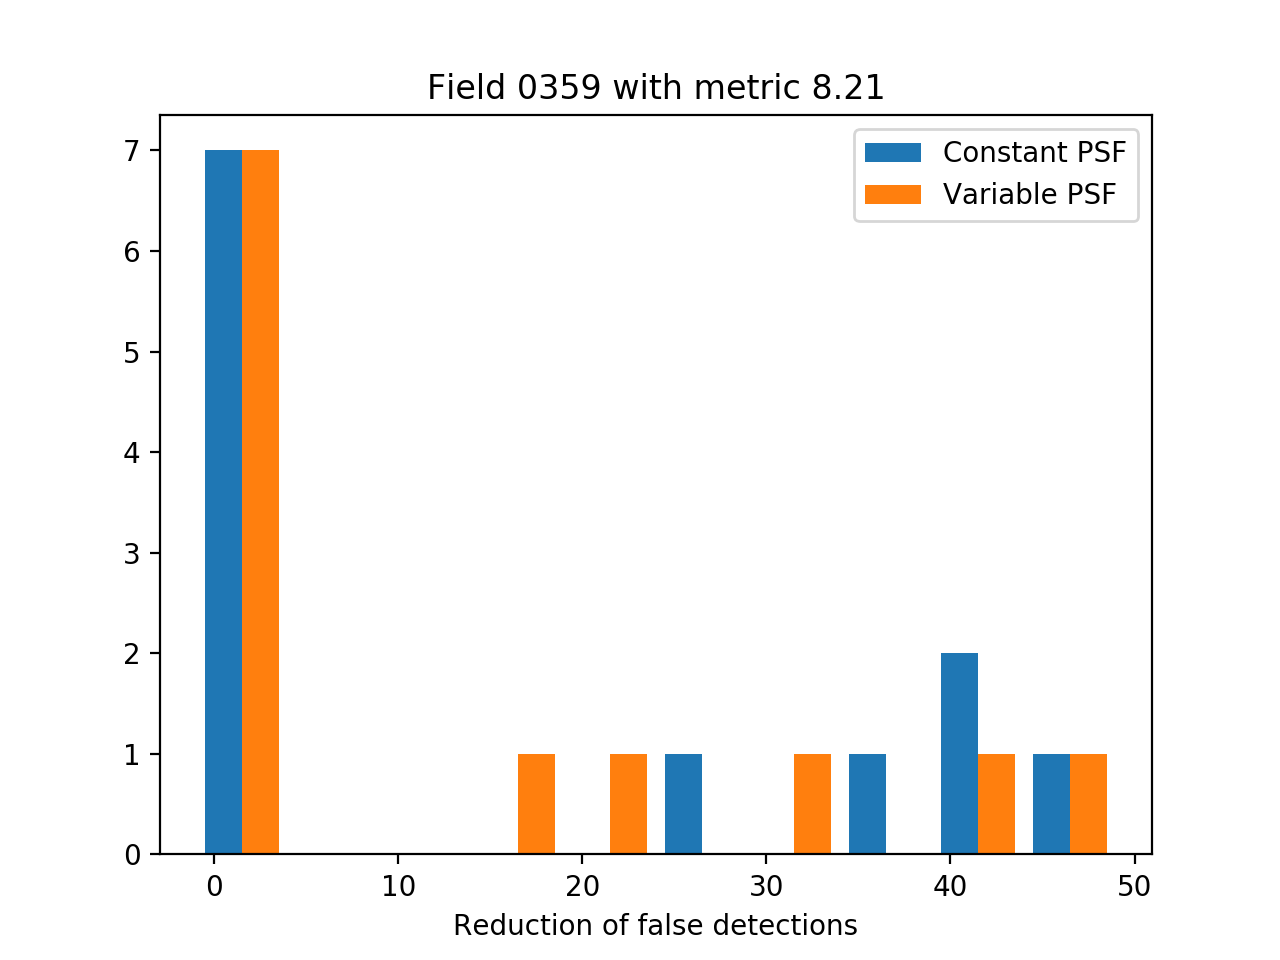

In [22]:
field = '0359'
deep_const = const_alerts_deep["nDipole"][const_alerts_deep["fieldId"] == field]
dcr_const = const_alerts_dcr["nDipole"][const_alerts_dcr["fieldId"] == field]
deep_var = var_alerts_deep["nDipole"][var_alerts_deep["fieldId"] == field]
dcr_var = var_alerts_dcr["nDipole"][var_alerts_dcr["fieldId"] == field]
plt.hist([deep_const - dcr_const, deep_var - dcr_var], histtype='bar')
plt.title("Field %s with metric %4.2f" % (field, metrics[field]))
plt.xlabel('Reduction of false detections')
plt.legend(["Constant PSF", "Variable PSF"])

In [27]:
def plot_diffim_quiver(deep_constPSF, dcr_constPSF, deep_varPSF, dcr_varPSF,
                       quantity="nDipole", window=1, **kwargs):
    field_list = list(set(deep_constPSF["fieldId"]))
    afwDisplay.Display(window)
    color_gen = get_xkcd_color()
    names = []
    for field in field_list:
        const_metric = dcr_metric(dcr_constPSF, field, binsize=0.05)
        var_metric = dcr_metric(dcr_varPSF, field, binsize=0.05)
        names.append("Field %s with metrics const:%4.2f var:%4.2f" % (field, const_metric, var_metric))
        q1a = deep_constPSF[quantity][deep_constPSF["fieldId"] == field]
        q2a = dcr_constPSF[quantity][dcr_constPSF["fieldId"] == field]
        q1b = deep_varPSF[quantity][deep_varPSF["fieldId"] == field]
        q2b = dcr_varPSF[quantity][dcr_varPSF["fieldId"] == field]
        x = q1a
        y = q1b
        dx = q2a - q1a
        dy = q2b - q1b
        c = 'xkcd:' + next(color_gen)
        plt.quiver(x, y, dx, dy, color=c, angles='xy', scale_units='xy', scale=1., **kwargs)
    plt.xlabel('False detections using constant PSF (deep -> dcr)')
    plt.ylabel('False detections using variable PSF with good seeing cut')
    plt.legend(names)

In [23]:
print("FieldId  \tmetric \tC deep \tC dcr  \tV deep \tV dcr")
for field in field_list:
    print("%s with metric %4.2f: \t%4.2f\t%4.2f \t%4.2f \t%4.2f" % (field, metrics[field],
                 np.mean(const_alerts_deep["nDipole"][const_alerts_deep["fieldId"] == field]),
                 np.mean(const_alerts_dcr["nDipole"][const_alerts_dcr["fieldId"] == field]),
                 np.mean(var_alerts_deep["nDipole"][var_alerts_deep["fieldId"] == field]),
                 np.mean(var_alerts_dcr["nDipole"][var_alerts_dcr["fieldId"] == field])))

FieldId  	metric 	C deep 	C dcr  	V deep 	V dcr
2682 with metric 7.58: 	14.71	3.43 	20.00 	10.00
2775 with metric 3.75: 	17.00	17.40 	15.40 	13.20
2874 with metric 5.71: 	50.33	14.00 	28.67 	20.00
2673 with metric 3.41: 	42.86	31.71 	44.43 	40.14
2725 with metric 4.87: 	6.23	0.69 	15.85 	4.31
2576 with metric 7.68: 	25.11	0.78 	22.67 	13.67
0359 with metric 8.21: 	17.17	1.00 	19.67 	6.08
2585 with metric 6.83: 	12.44	0.56 	12.22 	8.11
2733 with metric 6.22: 	14.75	14.42 	14.58 	15.25


In [24]:
cmap = plt.get_cmap("plasma")

In [25]:
def plot_diffim_quiver(deep_constPSF, dcr_constPSF, deep_varPSF, dcr_varPSF,
                       quantity="nDipole", window=1, **kwargs):
    field_list = list(set(deep_constPSF["fieldId"]))
    afwDisplay.Display(window)
    color_gen = get_xkcd_color()
    names = []
    for field in field_list:
        const_metric = dcr_metric(dcr_constPSF, field, binsize=0.05)
        var_metric = dcr_metric(dcr_varPSF, field, binsize=0.05)
        names.append("Field %s with metrics const:%4.2f var:%4.2f" % (field, const_metric, var_metric))
        q1a = deep_constPSF[quantity][deep_constPSF["fieldId"] == field]
        q2a = dcr_constPSF[quantity][dcr_constPSF["fieldId"] == field]
        q1b = deep_varPSF[quantity][deep_varPSF["fieldId"] == field]
        q2b = dcr_varPSF[quantity][dcr_varPSF["fieldId"] == field]
        x = q1a
        y = q1b
        dx = q2a - q1a
        dy = q2b - q1b
        c = 'xkcd:' + next(color_gen)
        plt.quiver(x, y, dx, dy, color=c, angles='xy', scale_units='xy', scale=1., **kwargs)
    plt.xlabel('False detections using constant PSF (deep -> dcr)')
    plt.ylabel('False detections using variable PSF with good seeing cut')
    plt.legend(names)

In [26]:
def plot_diffim_quiver(deep_table, dcr_table, template=None,
                       quantity="nDipole", window=1, psf_name='constant',
                       legend_location=4, metric_max=12., seeing_dict=None, **kwargs):
    field_list = list(set(deep_table["fieldId"]))
    afwDisplay.Display(window)
    color_gen = get_xkcd_color()
    names = []
    cmap = plt.get_cmap("plasma")
    plotQ = plt.figure(window)
    for field in field_list:
        if template is None:
            metric = dcr_metric(dcr_table, field, binsize=0.05)
            n_obs = np.sum(dcr_table["fieldId"] == field)
        else:
            metric = dcr_metric(template, field, binsize=0.05)
            n_obs = np.sum(template["fieldId"] == field)
        
        names.append("Field %s with metrics:%4.2f" % (field, metric))
        q1 = deep_table[quantity][deep_table["fieldId"] == field]
        q2 = dcr_table[quantity][dcr_table["fieldId"] == field]
        airmass = np.array(deep_table["airmass"][deep_table["fieldId"] == field])
        if seeing_dict is not None:
            visits = deep_table["visit"][deep_table["fieldId"] == field]
            seeing = [seeing_dict[visit] for visit in visits]
        else:
            seeing = np.zeros(len(airmass)) + .7
        parAng = np.array(deep_table["parAng"][deep_table["fieldId"] == field])
        x = q1
        y = airmass
        dx = q2 - q1
        dy = np.zeros(len(y))
        M = seeing
        c = 'xkcd:' + next(color_gen)
        plt.quiver(x, y, dx, dy, seeing, angles='xy', scale_units='xy', scale=1.,
                   cmap=plt.get_cmap('viridis'), **kwargs)
#     plt.yscale("linear", subsy=np.arange(1, 2, .1))
    plt.grid(True)
    plt.xlabel('False detections using %s PSF (deep -> dcr)' % psf_name)
    plt.ylabel('Airmass')
    cbar = plt.colorbar()
    cbar.ax.set_ylabel('Seeing (arcsec)')
    plt.clim(0.5, 2.0)
#     plt.legend(names, loc=legend_location)

<IPython.core.display.Javascript object>


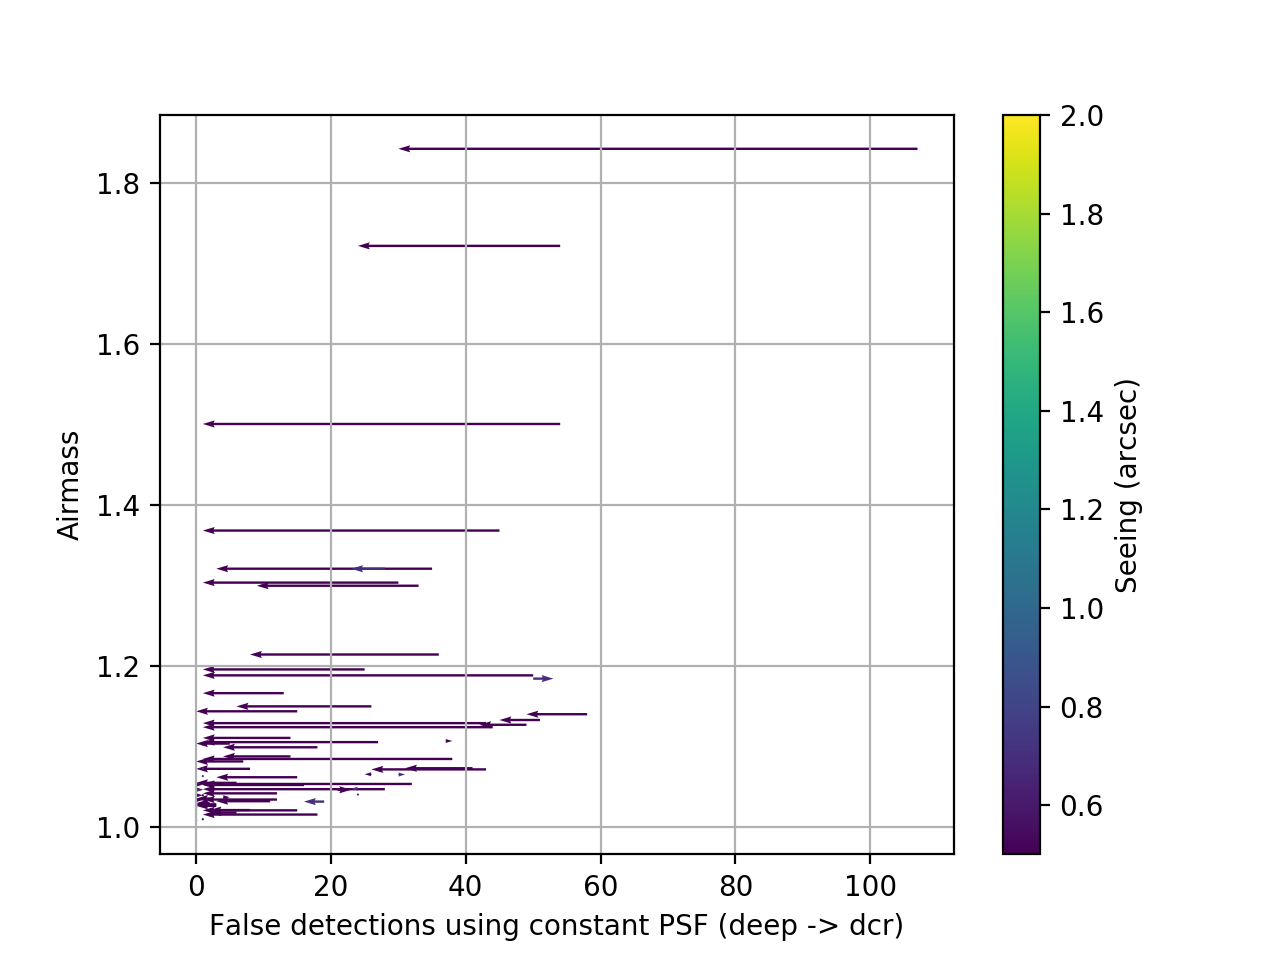

In [27]:
plot_diffim_quiver(const_alerts_deep, const_alerts_dcr, template=const_template_dcr,
                   psf_name='constant', window=3, width=3e-3)

<IPython.core.display.Javascript object>


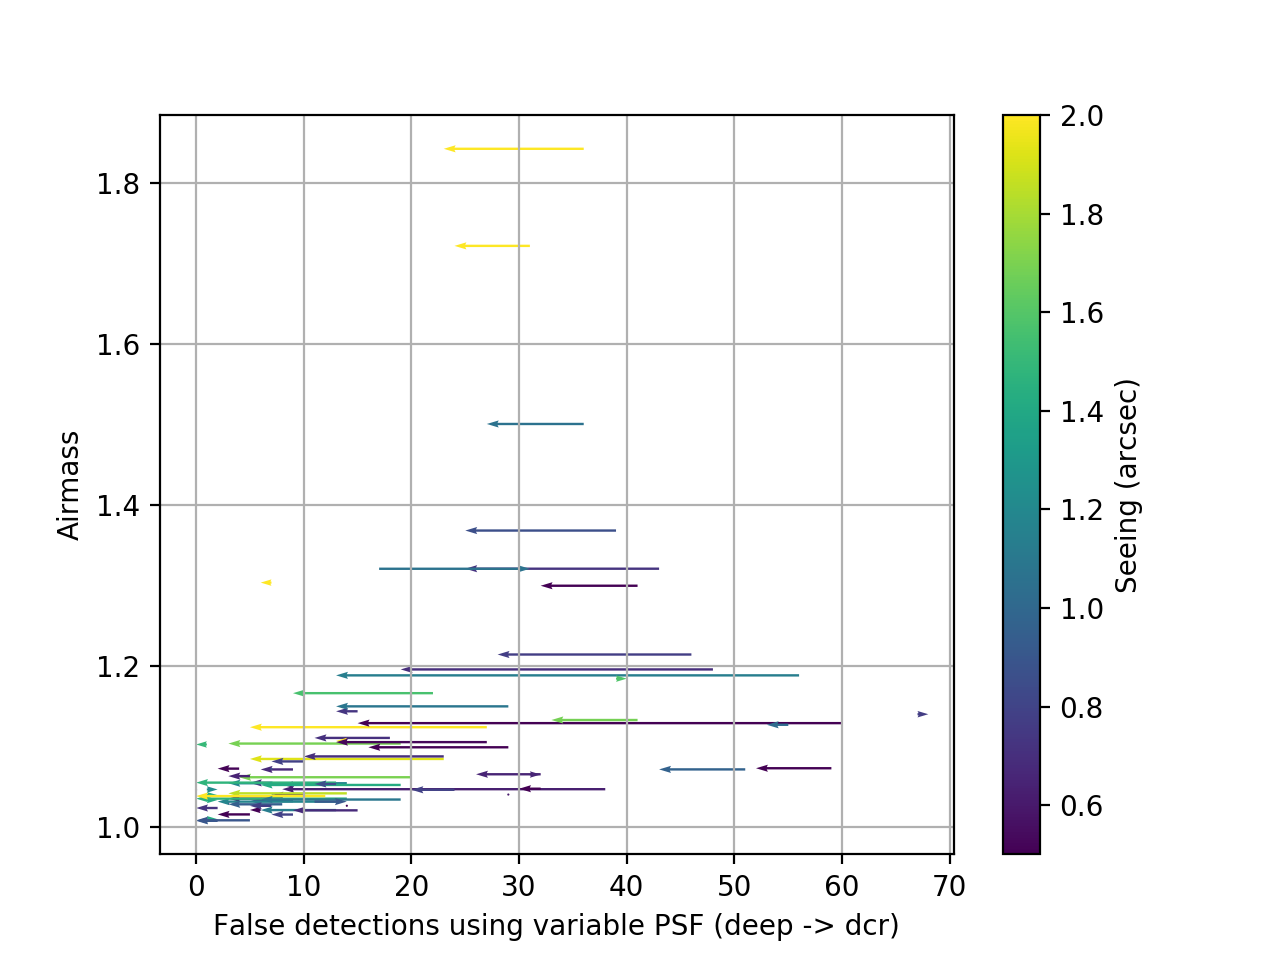

In [217]:
plot_diffim_quiver(var_alerts_deep, var_alerts_dcr, template=var_template_dcr,
                   psf_name='variable', window=4, width=3e-3, legend_location=1,
                   seeing_dict=seeing_dict)

<IPython.core.display.Javascript object>


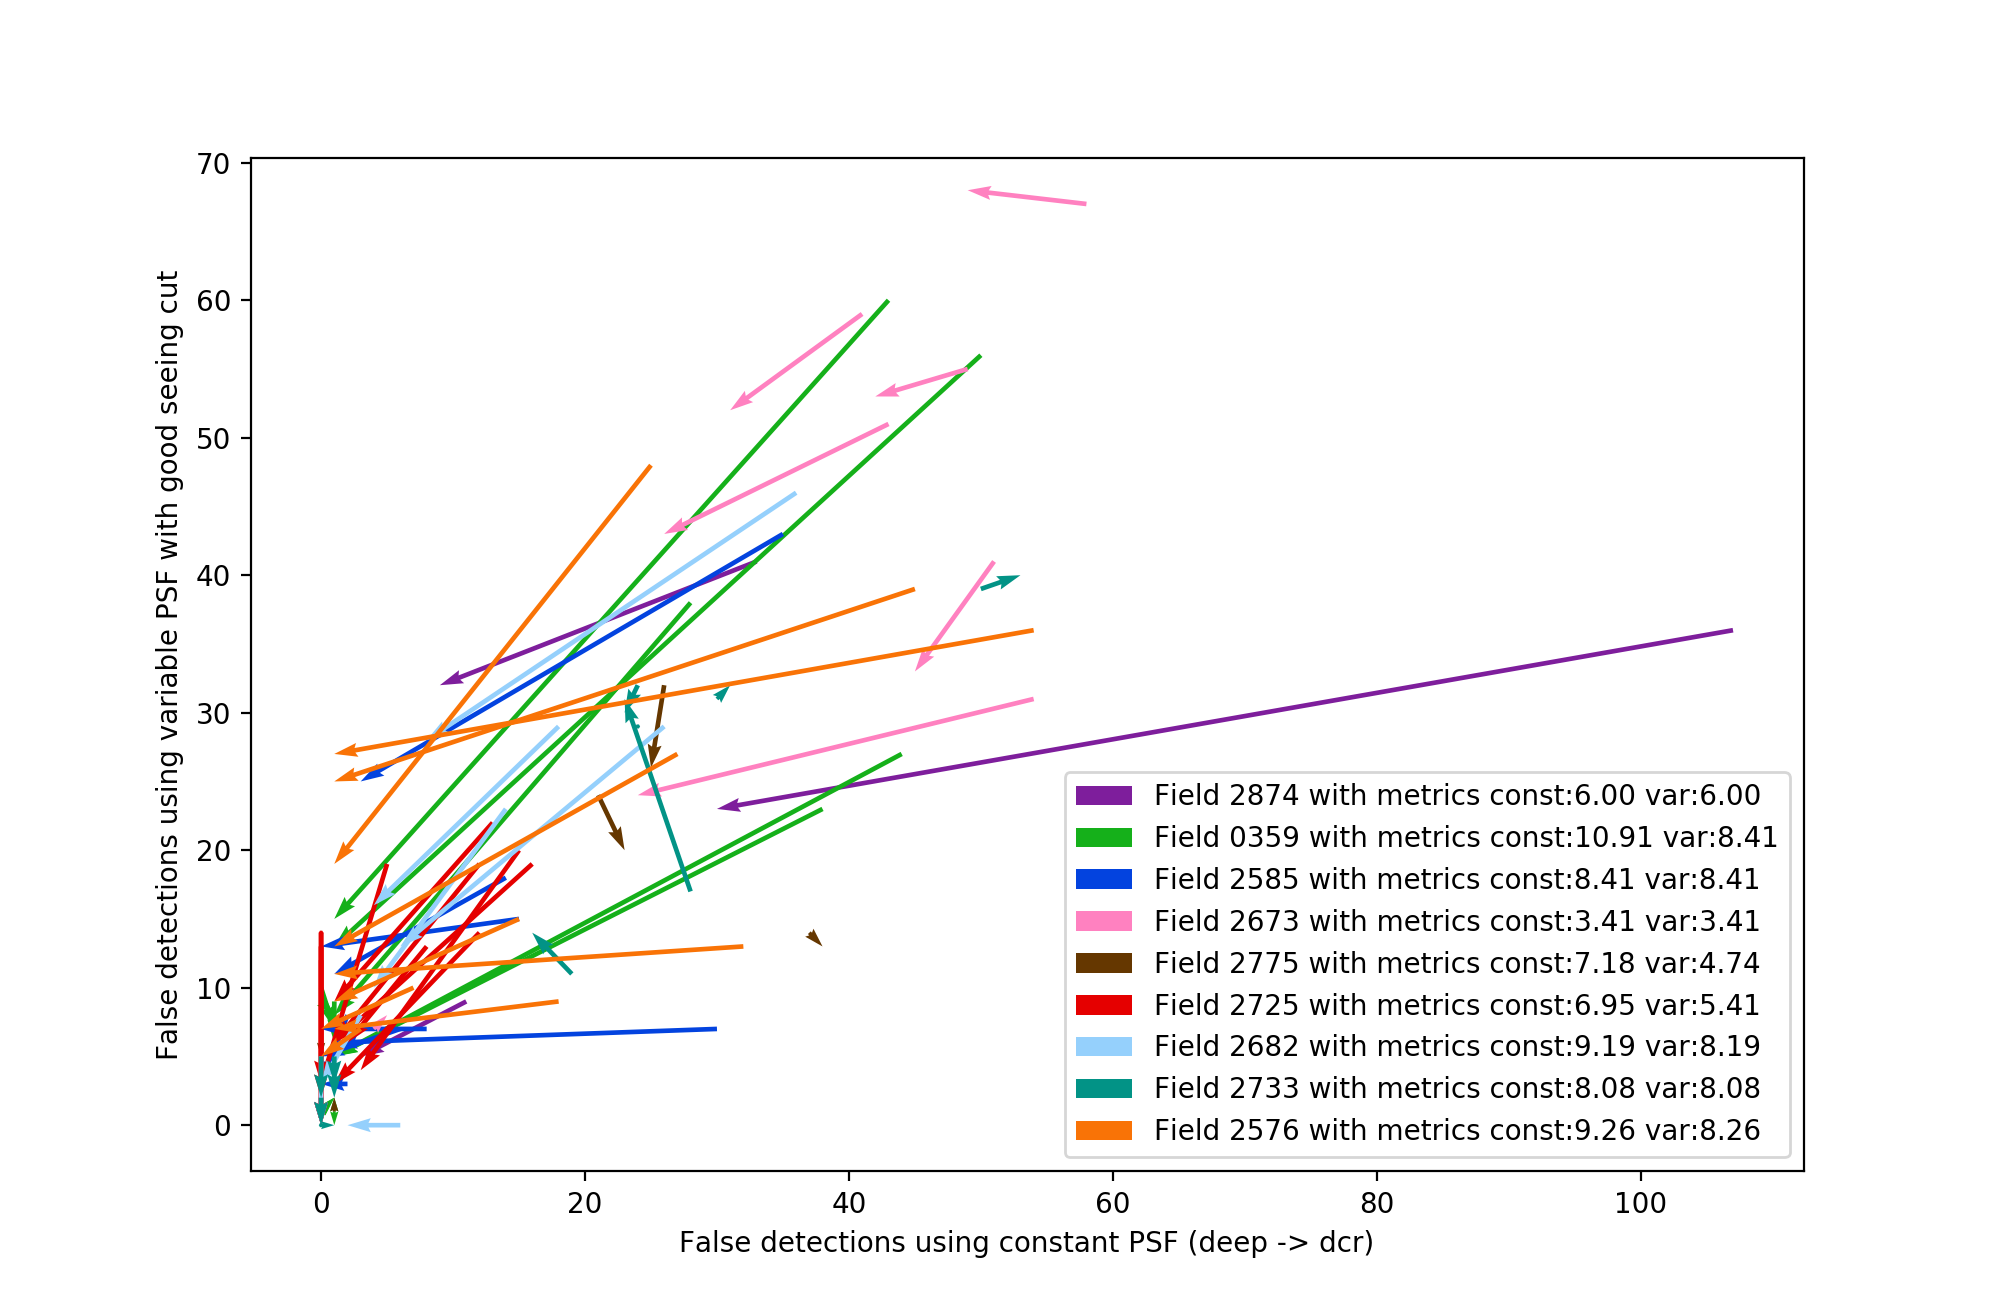

In [55]:
plot_diffim_quiver(const_alerts_deep, const_alerts_dcr, var_alerts_deep, var_alerts_dcr,
                   const_template=const_template_dcr, var_template=var_template_dcr,
                   window=3, width=3e-3)

Load the 2018 baseline survey

In [134]:
n_obs_list = [5, 8, 10]
repeat_obs = 3  # number of different fields with the given n_obs to generate simulations of
template_year = 1 
alert_year = 2
n_star = 10000
n_quasar = 1000

Connect to the database and set up for all of the simulations

Create a second set of simulations where the fields can be mosaiced together

In [136]:
airmass_threshold = 1.15  # Target fields must include at least one observation above this airmass to be included
opsim = OpSim_wrapper(year=template_year, filt='g', opsim_db='/Users/sullivan/LSST/OpSim/baseline2018a.db',
                      sim_directory="/Users/sullivan/LSST/simulations/OpSim/pontus_2568/",
                      conditions_db="/Users/sullivan/LSST/OpSim/pontus_2568.db",
                      airmass_threshold=airmass_threshold)

In [137]:
nx = repeat_obs
ny = len(n_obs_list)
n = nx if nx > ny else ny
simulation_size = n
dither_scale = 0.95
dither_x = dither_scale*(np.arange(nx) - (nx - 1)/2)
dither_y = dither_scale*(np.arange(ny) - (ny - 1)/2)

In [138]:
initial_const = True
initial_var = True
seed = 1
randomize_conditions = True
randomize_template = True

Make a text file containing the visit list, and save the observing conditions

In [153]:
visits = None
mosaic = True
randomize_conditions = True
band_dict = {'u': 0, 'g': 1, 'r': 2, 'i': 3, 'z': 4, 'y': 5}
seeing_dict = {}
airmass_dict = {}
for d_y, n_obs in zip(dither_y, n_obs_list):
    rng = np.random.RandomState(n_obs + 2)
    for rpt in range(repeat_obs):
        d_x = dither_x[rpt]
        index = int(np.rint(rng.rand()*1000))
        opsim.set_field(n_obs=n_obs, index=index, year=template_year)
        if randomize_template:
            opsim.update_year(template_year, randomize_conditions=randomize_conditions)
        n_obs1 = len(opsim.airmass)
        for t_i in range(n_obs1):
            fieldId_i = 100*opsim.field_Id + 1000000*template_year + t_i
            seeing_dict[fieldId_i] = opsim.seeing[t_i]
            airmass_dict[fieldId_i] = opsim.airmass[t_i]
        opsim.update_year(alert_year, randomize_conditions=randomize_conditions)
        n_obs2 = len(opsim.airmass)
        for t_i in range(n_obs2):
            fieldId_i = 100*opsim.field_Id + 1000000*alert_year + t_i
            seeing_dict[fieldId_i] = opsim.seeing[t_i]
            airmass_dict[fieldId_i] = opsim.airmass[t_i]
        if mosaic:
            visit_name1 = "%i" % (100*opsim.field_Id + 1000000*template_year)
            visit_name1b = "%i" % (100*opsim.field_Id + 1000000*template_year + n_obs1 - 1)
            visit_name2 = "%i" % (100*opsim.field_Id + 1000000*alert_year)
            visit_name2b = "%i" % (100*opsim.field_Id + 1000000*alert_year + n_obs2 - 1)
        else:
            visit_name1 = "%i" % (100*band_dict[opsim.filter] + 1000*template_year)
            visit_name1b = "%i" % (100*band_dict[opsim.filter] + 1000*template_year + n_obs1 - 1)
            visit_name2 = "%i" % (100*band_dict[opsim.filter] + 1000*alert_year)
            visit_name2b = "%i" % (100*band_dict[opsim.filter] + 1000*alert_year + n_obs2 - 1)
        if visits is None:
            visits = visit_name1
        else:
            visits += "^" + visit_name1
        visits += "..%s^%s..%s" % (visit_name1b, visit_name2, visit_name2b)

Selecting 10 obs from field 2682, with seeing range 0.541 to 0.815 and airmass range 1.158 to 1.209
Selecting 10 randomized obs from field 2682, with seeing range 0.504 to 1.019 and airmass range 1.021 to 1.509
Selecting 7 randomized obs from field 2682, with seeing range 0.675 to 1.210 and airmass range 1.007 to 1.207
Selecting 8 obs from field 2725, with seeing range 0.699 to 1.011 and airmass range 1.167 to 1.250
Selecting 8 randomized obs from field 2725, with seeing range 0.527 to 1.374 and airmass range 1.025 to 1.292
Selecting 13 randomized obs from field 2725, with seeing range 0.523 to 0.956 and airmass range 1.024 to 1.156
Selecting 6 obs from field 2874, with seeing range 0.575 to 0.759 and airmass range 1.204 to 1.271
Selecting 6 randomized obs from field 2874, with seeing range 0.542 to 0.781 and airmass range 1.034 to 1.247
Selecting 3 randomized obs from field 2874, with seeing range 0.745 to 1.422 and airmass range 1.034 to 1.879
Selecting 12 obs from field 359, with se